# Image segmentation for JetCar project

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# 1. Introduction

This notebook uses Semantic Segmentation to create a U-Net model. Training and validation data consist of a pair of

    a jpg image with 3 channels (RGB)
    a png mask with 1 channel contining the class values for each pixel
    
In addition there is a set of images in a third set to create predicted masks for as feedback.

The code is based on following examples:
    https://www.tensorflow.org/tutorials/images/segmentation
    
    https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/


# 2. Preparing the Environment

In [1]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa
from urllib.parse import urlparse
import zipfile

# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.1.0


In [2]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

In [3]:
import tensorflow as tf 
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2.1. Downloading the dataset

The data can be loaded from a local drive directly with path definitions below or downloaded from a google drive as shown in cells below.

In [4]:
GDRIVE_MOUNT = 'C:/Users/stefa/Python/tf-gpu/JetCar/Data/'
GDRIVE_PATH = GDRIVE_MOUNT
#GDRIVE_MOUNT = '/content/gdrive/'
#GDRIVE_PATH = GDRIVE_MOUNT+'JetCar'

#from google.colab import drive
#drive.mount(GDRIVE_MOUNT)
!ls 
!ls GDRIVE_MOUNT
!ls GDRIVE_PATH

'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
DOWNLOAD_URLS = [
      GDRIVE_PATH+'JetCar_DataSet.zip',
      GDRIVE_PATH+'JetCar_Recording.zip']

In [6]:
#Local drive path definitions if data is available locally
DATA_PATH = "~/tensorflow_datasets/JetCar/"
DATA_PATH = os.path.expanduser(DATA_PATH).replace('\\','/')
print(DATA_PATH)

C:/Users/stefa/tensorflow_datasets/JetCar/


In [7]:
DATASET_PATH = DATA_PATH + "DataSet/"
IMAGE_SUBDIR = "Img/"
TRAINING_SUBDIR = "train/"
VALIDATION_SUBDIR = "val/"
RECORDING_PATH = DATA_PATH +"Recording/"
PREDICTION_PATH = DATA_PATH +"Prediction/"
MODEL_WEIGHT_FILE_NAME = 'best_model.h5'
PREDICTION_ZIP_FILE_NAME = 'pPrediction.zip'

## 3. Creating our Dataloader

In [8]:
# Image size that we are going to use
IMG_SIZE = 224 
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 22 classes including 'nothing'=0
N_CLASSES = 22

In [9]:
def download(source_url, destination_path=None, overwrite=False):

    if destination_path is None:
        fname = source_url.split('/')[-1]
    else:
        destination_path = os.path.expanduser(destination_path)
        if os.path.isdir(destination_path):
            fname = os.path.join(destination_path, source_url.split('/')[-1])
        else:
            fname = destination_path

    if overwrite or not os.path.exists(fname):
        dirname = os.path.dirname(os.path.abspath(os.path.expanduser(fname)))
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        scheme = urlparse(source_url).scheme
        if scheme == 'http' or scheme == 'https':
            print('Downloading %s from %s...'%(fname, source_url))
            r = requests.get(source_url, stream=True)
            if r.status_code != 200:
                raise RuntimeError("Failed downloading url %s"%url)
            total_length = r.headers.get('content-length')
           
            with open(fname, 'wb') as f:
                if total_length is None: # no content length header
                    for chunk in r.iter_content(chunk_size=1024):
                        if chunk: # filter out keep-alive new chunks
                            f.write(chunk)
                else:
                    total_length = int(total_length)
                    for chunk in tqdm(r.iter_content(chunk_size=1024),
                                      total=int(total_length / 1024. + 0.5),
                                      unit='KB', unit_scale=False, dynamic_ncols=True):
                        f.write(chunk)

        else:
            print('Copying %s from %s...'%(os.path.normpath(fname), os.path.normpath(source_url)))
            tf.io.gfile.copy(os.path.normpath(source_url), os.path.normpath(fname), overwrite)

    return fname

def download_dataset(source_urls, destination_path, overwrite=False):
    if not os.path.exists(destination_path):
        os.mkdir(destination_path)
    download_dir = os.path.join(destination_path, 'downloads')
    if not os.path.exists(download_dir):
        os.mkdir(download_dir)
    for url in source_urls:
        filename = download(source_url=url, destination_path=download_dir, overwrite=overwrite)
        # extract
        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall(path=destination_path)

In [10]:
download_dataset(DOWNLOAD_URLS, DATA_PATH, overwrite=False)

In [11]:
if os.path.exists(GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME):
    print('Copying %s from %s...'%(MODEL_WEIGHT_FILE_NAME, GDRIVE_PATH))
    tf.io.gfile.copy(os.path.normpath(GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME), 
                 os.path.normpath(DATA_PATH + MODEL_WEIGHT_FILE_NAME), True)

Copying best_model.h5 from C:/Users/stefa/Python/tf-gpu/JetCar/Data/...


### 3.1. Creating a source dataset

In addition to training and validation data sets, there is another image only dataset to create prediction masks from. These masks are used as feedback for adjusting the classification if needed.

In [12]:
TRAINSET_SIZE = len(glob(DATASET_PATH + IMAGE_SUBDIR + TRAINING_SUBDIR + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(DATASET_PATH + IMAGE_SUBDIR + VALIDATION_SUBDIR + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

PREDSET_SIZE = len(glob(RECORDING_PATH + "*.jpg"))
print(f"The Prediction Dataset contains {PREDSET_SIZE} images.")

The Training Dataset contains 30375 images.
The Validation Dataset contains 3930 images.
The Prediction Dataset contains 147 images.


For each images of our dataset, we will apply some operations wrapped into a function. Then we will map the whole dataset with this function.   

So let's write this function:

In [13]:
 def parse_dataset_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "Img", "Mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)

    return {'image': image, 'segmentation_mask': mask}


def parse_recording_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return {'image': image, 'img_path': img_path}

In [14]:
train_dataset = tf.data.Dataset.list_files(DATASET_PATH + IMAGE_SUBDIR + TRAINING_SUBDIR + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_dataset_image)

val_dataset = tf.data.Dataset.list_files(DATASET_PATH + IMAGE_SUBDIR + VALIDATION_SUBDIR + "*.jpg", seed=SEED)
val_dataset = val_dataset.map(parse_dataset_image)

pred_dataset = tf.data.Dataset.list_files(RECORDING_PATH + "*.jpg", seed=SEED)
pred_dataset = pred_dataset.map(parse_recording_image)

### 3.2. Applying some transformations to our dataset

In [15]:
"""Resize and normalize"""
@tf.function
def load_image_train_val(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_pred(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, datapoint['img_path']

Manipulating datasets in tensorflow can be complicated. You can read the official documentation to understand how they are working: https://www.tensorflow.org/guide/data#training_workflows

In [16]:
BATCH_SIZE = 10
BUFFER_SIZE = 1000
TRAIN_LENGTH = TRAINSET_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

dataset = {"train": train_dataset, "val": val_dataset, "pred": pred_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_train_val)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

#-- Prediction Dataset --#
dataset['pred'] = dataset['pred'].map(load_image_pred)
dataset['pred'] = dataset['pred'].batch(BATCH_SIZE)
dataset['pred'] = dataset['pred'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['pred'])

print("TRAIN_LENGTH = %d   STEPS_PER_EPOCH = %d " %(TRAIN_LENGTH,STEPS_PER_EPOCH))

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>
TRAIN_LENGTH = 30375   STEPS_PER_EPOCH = 3037 


In [17]:
train = dataset['train']
test = dataset['val']
pred = dataset['pred']

Let's take a look at an image example and it's correponding mask from the dataset.

In [18]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

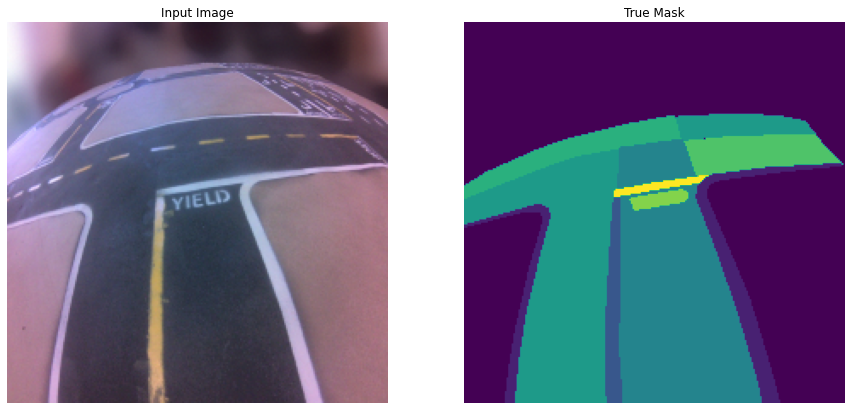

In [19]:
for image, mask in train.take(1):
  sample_image, sample_mask = image[0], mask[0]
display([sample_image, sample_mask])

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [20]:
OUTPUT_CHANNELS = N_CLASSES
IMG_WIDTH=IMG_SIZE
IMG_HEIGHT=IMG_SIZE

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_WIDTH, IMG_HEIGHT, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [22]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [23]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [24]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [25]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer=Adam(learning_rate=0.0001),
              #optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
if os.path.exists(DATA_PATH + MODEL_WEIGHT_FILE_NAME): 
    model.load_weights(DATA_PATH + MODEL_WEIGHT_FILE_NAME)
    print('model weights loaded!')

model weights loaded!


Have a quick look at the resulting model architecture:

In [27]:
#tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [28]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

In [29]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      pred_mask = create_mask(pred_mask);
      display([image[0], mask[0], pred_mask[0] ])
  else:
    pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))[0]
    display([sample_image, sample_mask, pred_mask ])

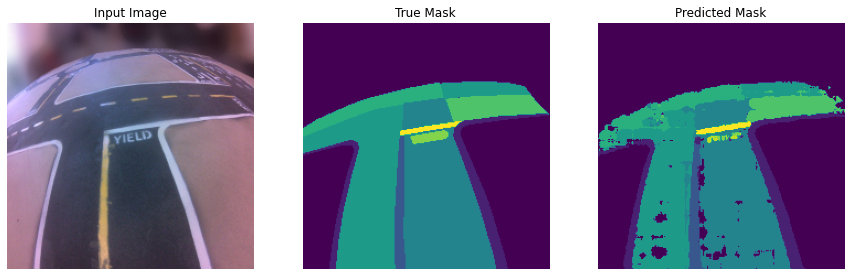

In [30]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [31]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #import pdb; pdb.set_trace()
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [32]:
EPOCHS = 3 #1000
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE
PREDICTION_STEPS = PREDSET_SIZE // BATCH_SIZE

print("STEPS_PER_EPOCH = %d   VALIDATION_STEPS = %d   PREDICTION_STEPS = %d " 
      %(STEPS_PER_EPOCH, VALIDATION_STEPS, PREDICTION_STEPS))

STEPS_PER_EPOCH = 3037   VALIDATION_STEPS = 393   PREDICTION_STEPS = 14 


In [33]:
log_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", log_name)

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=25, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint(DATA_PATH + MODEL_WEIGHT_FILE_NAME, 
                                       verbose=1, save_best_only=True, save_weights_only=True)
]


In [35]:
# Load the TensorBoard notebook extension.
#%load_ext tensorboard
#%tensorboard --logdir logs

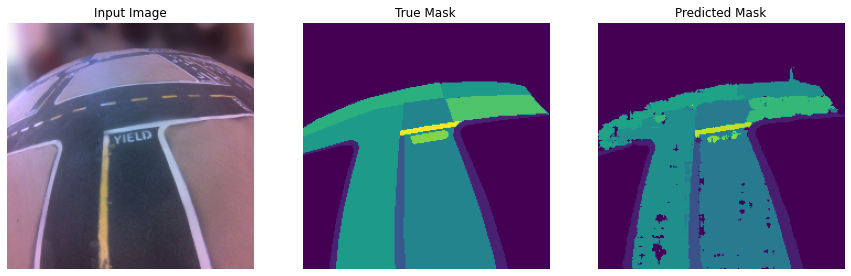


Sample Prediction after epoch 3


Epoch 00003: val_loss improved from 0.42426 to 0.39506, saving model to C:/Users/stefa/tensorflow_datasets/JetCar/best_model.h5
3037/3037 [==============================] - 1203s 396ms/step - loss: 0.0237 - accuracy: 0.9904 - val_loss: 0.3951 - val_accuracy: 0.8878


In [36]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset['val'],
                    callbacks=callbacks)

In [37]:
if os.path.exists(DATA_PATH + MODEL_WEIGHT_FILE_NAME): 
    print('Copying %s to %s...'%(MODEL_WEIGHT_FILE_NAME, GDRIVE_PATH))
    tf.io.gfile.copy(os.path.normpath(DATA_PATH + MODEL_WEIGHT_FILE_NAME), 
                     os.path.normpath(GDRIVE_PATH + MODEL_WEIGHT_FILE_NAME), True)

Copying best_model.h5 to C:/Users/stefa/Python/tf-gpu/JetCar/Data/...


In [39]:
import zipfile
if os.path.exists(logdir): 
    print("Compressing logs")
    zipFileName = logdir+".zip"
    zipObj = zipfile.ZipFile(zipFileName, 'w')
    zipObj.write(logdir)
    zipObj.close()
    print('Copying %s to %s...'%(zipFileName, GDRIVE_PATH))
    tf.io.gfile.copy(os.path.normpath(zipFileName), 
                     os.path.normpath(GDRIVE_PATH + log_name+".zip"), True)

Compressing logs
Copying logs\20201021-085522.zip to C:/Users/stefa/Python/tf-gpu/JetCar/Data/...


## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [ ]:
if not os.path.exists(PREDICTION_PATH):
    os.makedirs(PREDICTION_PATH)

In [ ]:
if os.path.exists(PREDICTION_PATH + PREDICTION_ZIP_FILE_NAME):
    tf.io.gfile.remove(PREDICTION_PATH + PREDICTION_ZIP_FILE_NAME)

In [ ]:
import zipfile
zipObj = zipfile.ZipFile(PREDICTION_PATH+PREDICTION_ZIP_FILE_NAME, 'w')

In [ ]:
n=0
for step, (image_batch, filename_batch) in enumerate(pred):
    pred_batch = create_mask(model.predict(image_batch))
    for i in range(image_batch.shape[0]):
        base_filename = filename_batch[i].numpy().decode('ascii')
        base_filename = os.path.basename(base_filename)
        base_filename = os.path.splitext(base_filename)[0]
        pred_filename = base_filename.replace("Img","Pred")+".png"
        n = n+1
        print(f"Saving file #{n}: " + pred_filename)
        tf.keras.preprocessing.image.save_img(PREDICTION_PATH + pred_filename, pred_batch[i], scale=False)
        zipObj.write(PREDICTION_PATH + pred_filename)

In [ ]:
zipObj.close()

In [ ]:
print('Copying %s to %s...'%(PREDICTION_ZIP_FILE_NAME, GDRIVE_PATH))
tf.io.gfile.copy(os.path.normpath(PREDICTION_PATH+PREDICTION_ZIP_FILE_NAME), 
                 os.path.normpath(GDRIVE_PATH+PREDICTION_ZIP_FILE_NAME), True)